In [1]:
import numpy as np
from astropy.stats import bayesian_blocks
import matplotlib.pyplot as plt
import kdsource as kds

df = kds.SurfaceSourceFile(
    "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/ssf_N17b_C5_trf.h5",
    domain={"w": [0, 2]},
).get_pandas_dataframe()[["x", "y", "ln(E0/E)", "mu", "phi", "wgt"]]

Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/ssf_N17b_C5_trf.h5: 45840
100% n, 0% g, 0% e-, 0% e+, 0% p, 


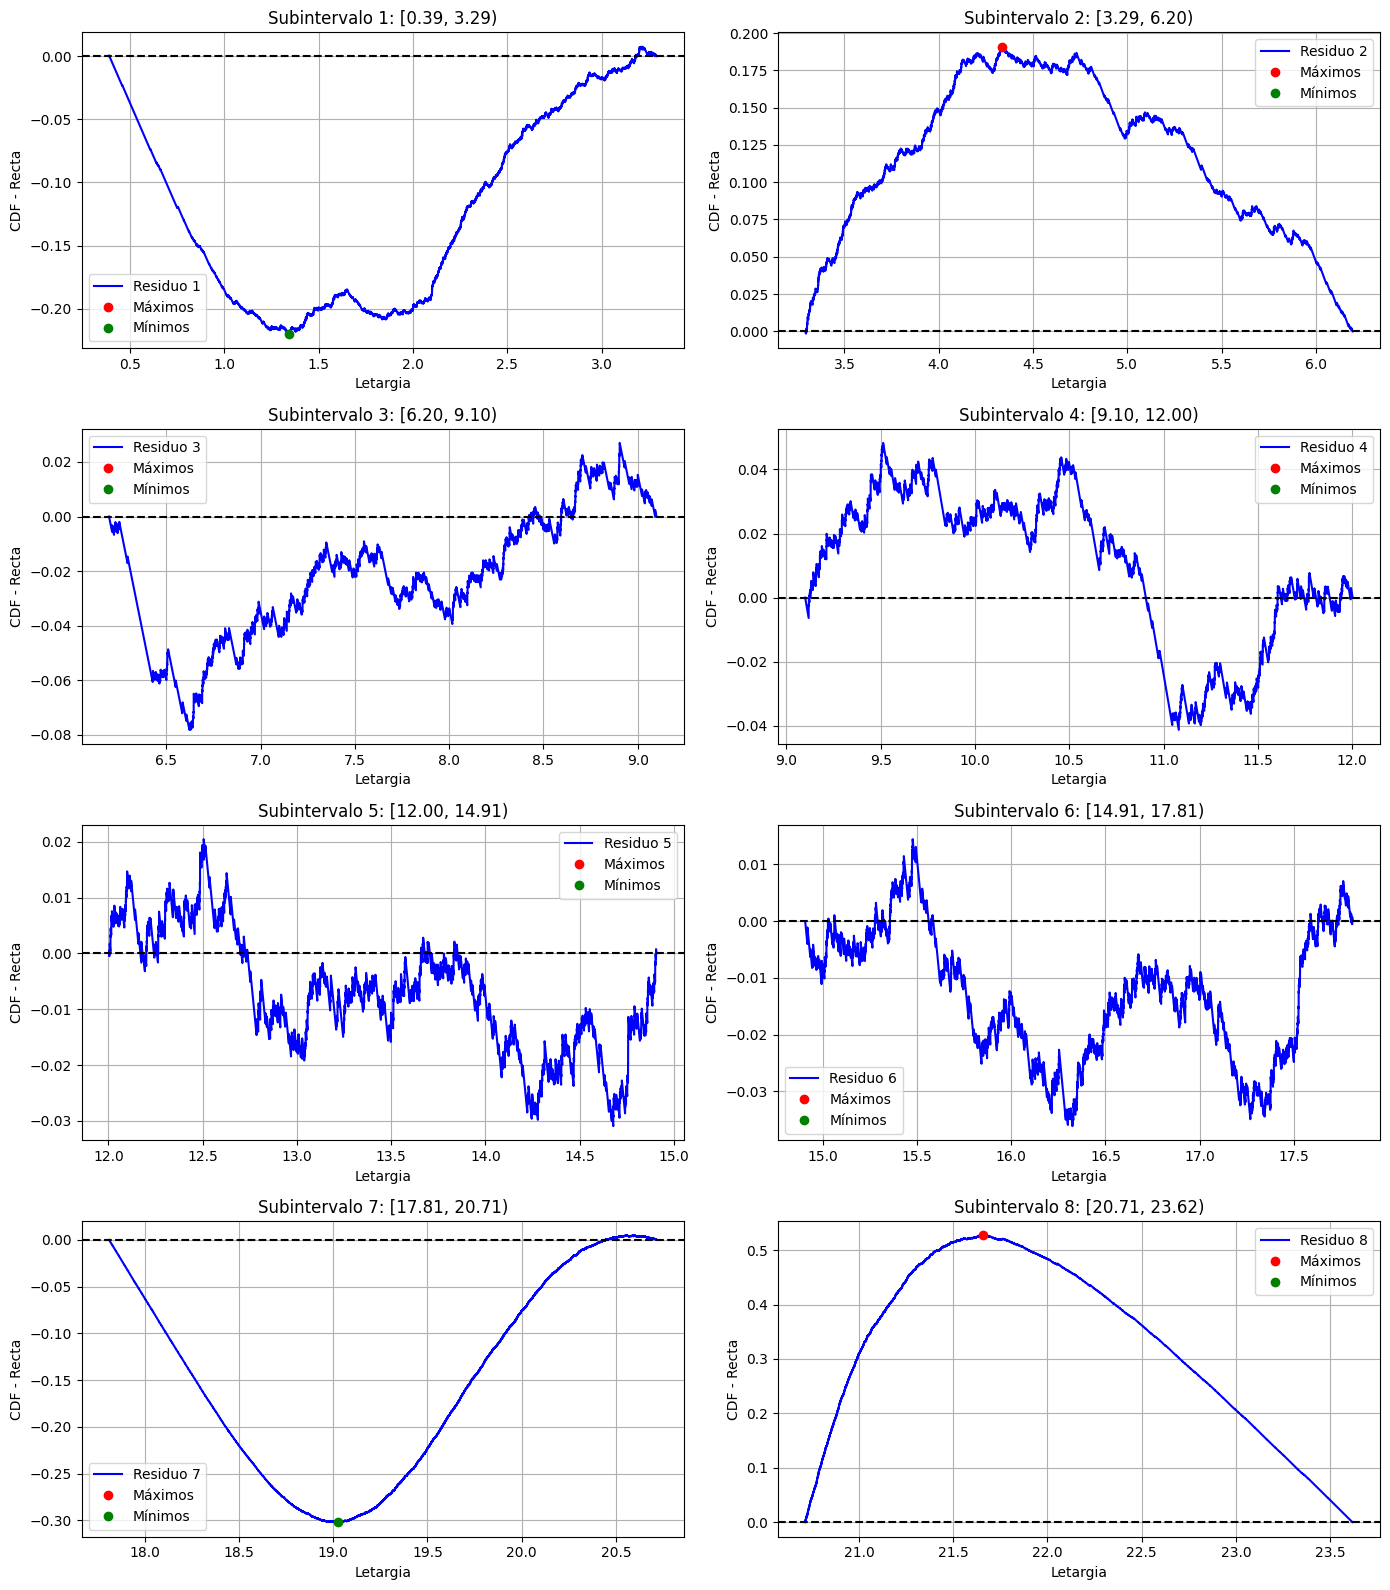

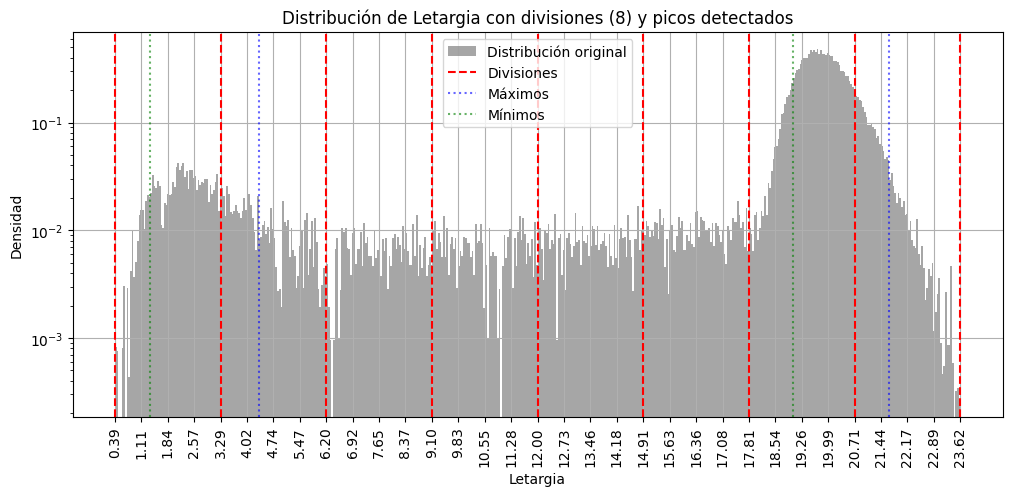


===== Líneas verticales trazadas =====

🔴 Límites de subintervalos (9):
[ 0.38764702  3.29152634  6.19540566  9.09928498 12.00316429 14.90704361
 17.81092293 20.71480225 23.61868157]

🔵 Picos máximos detectados (2):
[ 4.33809025 21.65822908]

🟢 Picos mínimos detectados (2):
[ 1.34257902 19.02502907]


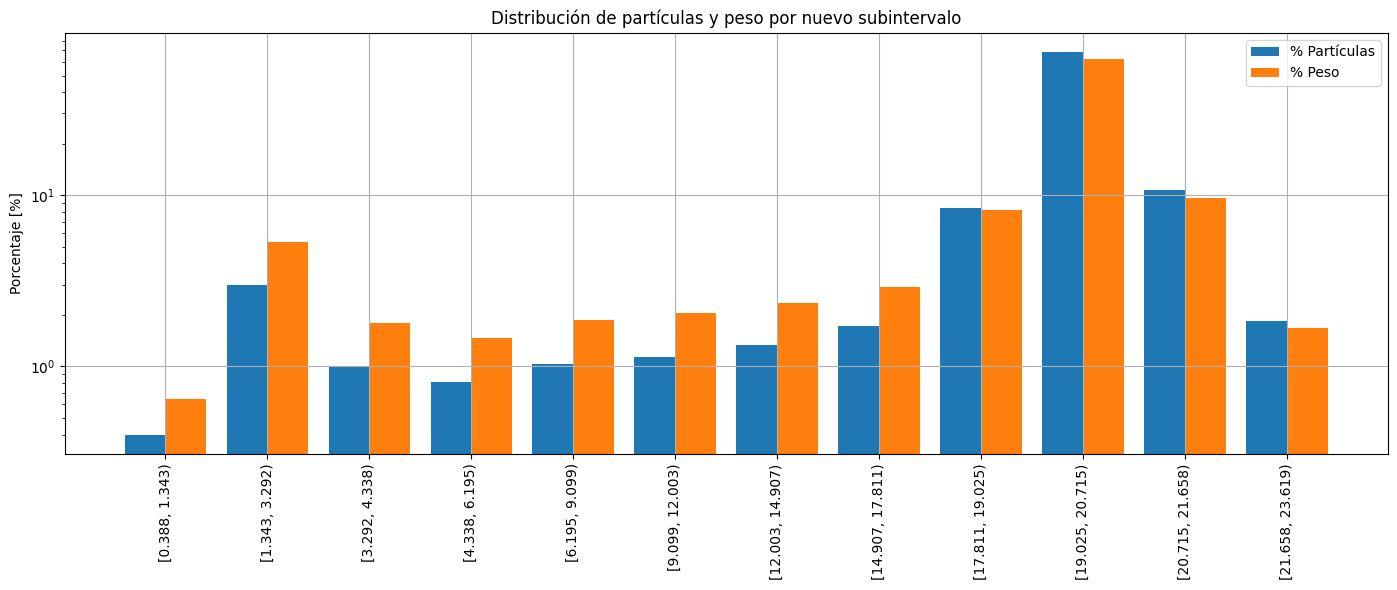

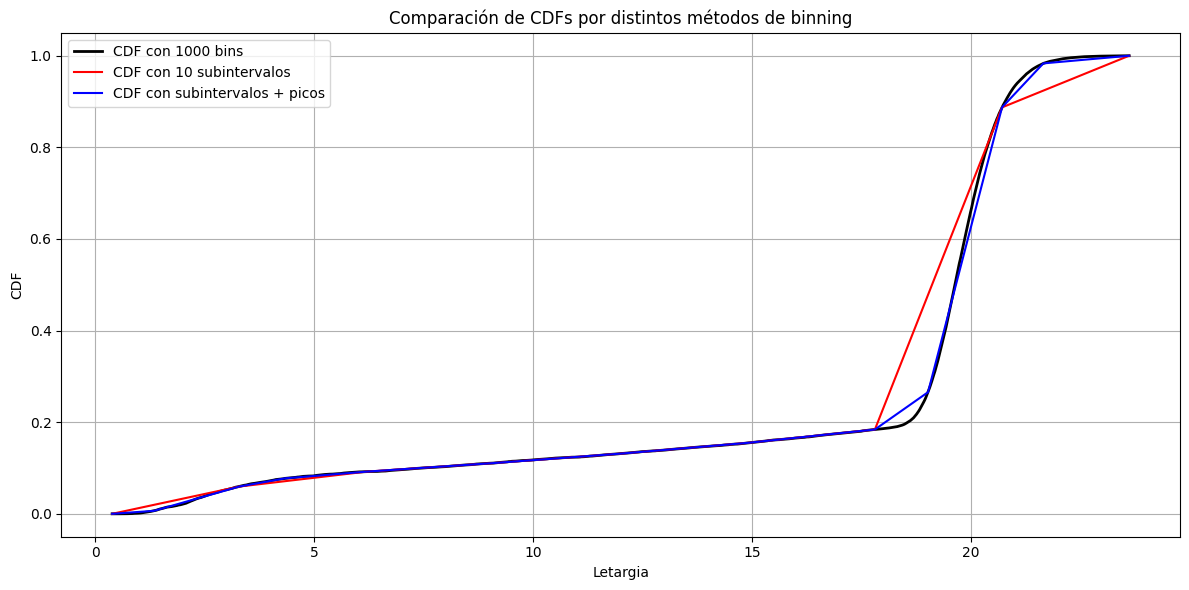

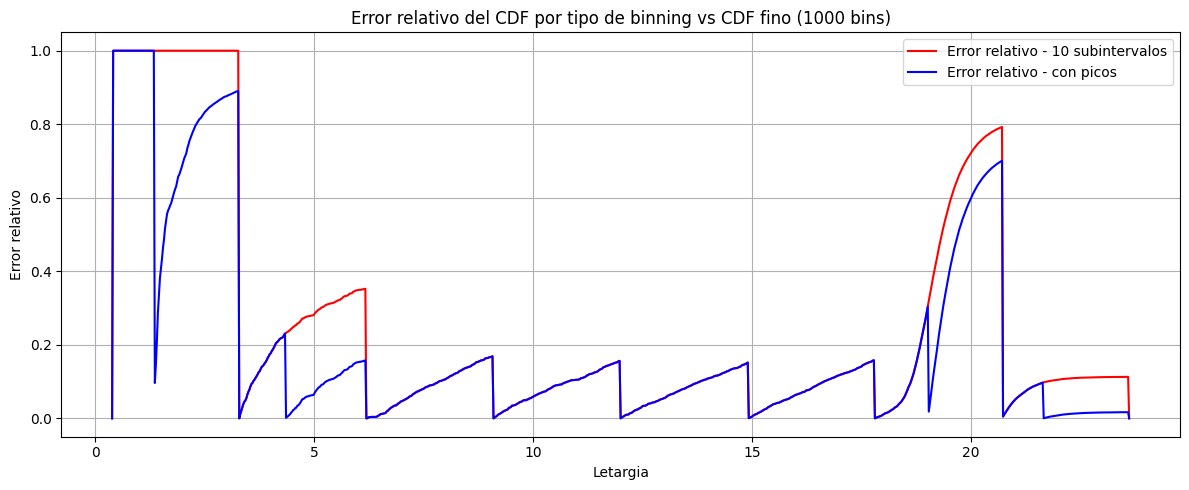

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# === 🔧 CONFIGURACIÓN GENERAL ===
n_subs = 8  # ← Cambiá esto para ajustar la cantidad de subintervalos
bins_residuo = int(1e6)
prominence_val = 0.1

# === 📥 DATOS ===
letargia = df["ln(E0/E)"].to_numpy()
pesos = df["wgt"].to_numpy()

# Subintervalos equiespaciados
min_l, max_l = np.min(letargia), np.max(letargia)
subintervalos = np.linspace(min_l, max_l, n_subs + 1)

# === 📈 Subgráficos de residuos y picos ===
n_filas = int(np.ceil(n_subs / 2))
fig, axs = plt.subplots(n_filas, 2, figsize=(14, 4 * n_filas))
axs = axs.flatten()

peaks_globales = []
troughs_globales = []

for i in range(n_subs):
    lmin = subintervalos[i]
    lmax = subintervalos[i + 1]

    if i < n_subs - 1:
        mask = (letargia >= lmin) & (letargia < lmax)
    else:
        mask = (letargia >= lmin) & (letargia <= lmax)
    l_sub = letargia[mask]
    w_sub = pesos[mask]

    if len(l_sub) == 0:
        continue

    counts, bin_edges = np.histogram(
        l_sub, bins=bins_residuo, range=(lmin, lmax), weights=w_sub, density=True
    )
    cdf = np.insert(np.cumsum(counts * np.diff(bin_edges)), 0, 0)
    cdf /= cdf[-1]
    residuo = cdf - np.linspace(0, 1, len(cdf))

    peaks, _ = find_peaks(residuo, prominence=prominence_val)
    troughs, _ = find_peaks(-residuo, prominence=prominence_val)

    x_peaks = bin_edges[peaks]
    y_peaks = residuo[peaks]
    x_troughs = bin_edges[troughs]
    y_troughs = residuo[troughs]

    peaks_globales.extend(x_peaks)
    troughs_globales.extend(x_troughs)

    axs[i].plot(bin_edges, residuo, label=f"Residuo {i+1}", color="blue")
    axs[i].plot(x_peaks, y_peaks, "ro", label="Máximos")
    axs[i].plot(x_troughs, y_troughs, "go", label="Mínimos")
    axs[i].set_title(f"Subintervalo {i+1}: [{lmin:.2f}, {lmax:.2f})")
    axs[i].set_xlabel("Letargia")
    axs[i].set_ylabel("CDF - Recta")
    axs[i].axhline(0, color="black", linestyle="--")
    axs[i].legend()
    axs[i].grid()

plt.tight_layout()
plt.show()

# === 📊 Histograma global con divisiones y picos ===
plt.figure(figsize=(12, 5))
plt.hist(
    letargia,
    bins=500,
    weights=pesos,
    density=True,
    color="gray",
    alpha=0.7,
    label="Distribución original",
)

for edge in subintervalos:
    plt.axvline(
        edge,
        color="red",
        linestyle="--",
        label="Divisiones" if edge == subintervalos[0] else "",
    )

for i, pk in enumerate(peaks_globales):
    plt.axvline(
        pk, color="blue", linestyle=":", alpha=0.6, label="Máximos" if i == 0 else ""
    )

for i, tr in enumerate(troughs_globales):
    plt.axvline(
        tr, color="green", linestyle=":", alpha=0.6, label="Mínimos" if i == 0 else ""
    )

plt.title(f"Distribución de Letargia con divisiones ({n_subs}) y picos detectados")
plt.xlabel("Letargia")
plt.ylabel("Densidad")
plt.legend()
plt.grid()
plt.xticks(np.linspace(min_l, max_l, 4 * n_subs + 1), rotation=90)
plt.yscale("log")
plt.show()

# === 🖨️ Imprimir posiciones de todas las líneas verticales ===
print("\n===== Líneas verticales trazadas =====")
print(f"\n🔴 Límites de subintervalos ({len(subintervalos)}):")
print(subintervalos)

print(f"\n🔵 Picos máximos detectados ({len(peaks_globales)}):")
print(np.array(peaks_globales))

print(f"\n🟢 Picos mínimos detectados ({len(troughs_globales)}):")
print(np.array(troughs_globales))

# === 🧮 NUEVA DEFINICIÓN DE SUBINTERVALOS ===
# Unir subintervalos originales y picos
new_edges = np.concatenate([subintervalos, peaks_globales, troughs_globales])
new_edges = np.unique(np.sort(new_edges))

# Inicializar contadores
total_particulas = len(letargia)
total_peso = np.sum(pesos)

porcentajes_particulas = []
porcentajes_peso = []
labels = []

for i in range(len(new_edges) - 1):
    lmin = new_edges[i]
    lmax = new_edges[i + 1]

    # Último intervalo debe incluir el borde superior
    if i < len(new_edges) - 2:
        mask = (letargia >= lmin) & (letargia < lmax)
    else:
        mask = (letargia >= lmin) & (letargia <= lmax)

    count = np.sum(mask)
    peso = np.sum(pesos[mask])

    porcentaje_part = 100 * count / total_particulas
    porcentaje_wgt = 100 * peso / total_peso

    porcentajes_particulas.append(porcentaje_part)
    porcentajes_peso.append(porcentaje_wgt)
    labels.append(f"[{lmin:.3f}, {lmax:.3f})")

# === 📊 PLOT DE PARTICULAS Y PESO EN CADA NUEVO INTERVALO ===
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(14, 6))
bar1 = ax.bar(x - 0.2, porcentajes_particulas, width=0.4, label="% Partículas")
bar2 = ax.bar(x + 0.2, porcentajes_peso, width=0.4, label="% Peso")

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel("Porcentaje [%]")
ax.set_title("Distribución de partículas y peso por nuevo subintervalo")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.yscale("log")
plt.show()

# === 📊 COMPARACIÓN DE CDFs ===


# Función auxiliar para construir CDF a trozos desde una lista de bordes
def construir_cdf_por_tramos(edges, letargia, pesos):
    xs = [edges[0]]         # arranca en el primer borde
    ys = [0.0]              # y con valor 0

    total_peso = np.sum(pesos)
    acumulado = 0.0

    for i in range(len(edges) - 1):
        lmin = edges[i]
        lmax = edges[i + 1]

        if i < len(edges) - 2:
            mask = (letargia >= lmin) & (letargia < lmax)
        else:
            mask = (letargia >= lmin) & (letargia <= lmax)

        peso_intervalo = np.sum(pesos[mask])
        acumulado += peso_intervalo

        xs.append(lmax)
        ys.append(acumulado / total_peso)

    return np.array(xs), np.array(ys)


# === 1. CDF fino con 1000 bins ===
counts_fino, bins_fino = np.histogram(letargia, bins=1000, weights=pesos, density=True)
cdf_fino = np.insert(np.cumsum(counts_fino * np.diff(bins_fino)), 0, 0)
cdf_fino /= cdf_fino[-1]

# === 2. CDF con los 10 subintervalos originales ===
x_10, y_10 = construir_cdf_por_tramos(subintervalos, letargia, pesos)

# === 3. CDF con subintervalos + picos ===
x_peaks_cdf, y_peaks_cdf = construir_cdf_por_tramos(new_edges, letargia, pesos)

# === PLOT COMPARATIVO ===
plt.figure(figsize=(12, 6))

# CDF fino (interpolado para suavizar)
plt.plot(bins_fino, cdf_fino, label="CDF con 1000 bins", color="black", linewidth=2)

# CDF con 10 intervalos
plt.plot(x_10, y_10, label="CDF con 10 subintervalos", color="red")

# CDF con subintervalos + peaks
plt.plot(x_peaks_cdf, y_peaks_cdf, label="CDF con subintervalos + picos", color="blue")

plt.xlabel("Letargia")
plt.ylabel("CDF")
plt.title("Comparación de CDFs por distintos métodos de binning")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from scipy.interpolate import interp1d

# Interpoladores de los CDF a tramos sobre el eje de bins_fino
interp_10 = interp1d(x_10, y_10, kind="previous", bounds_error=False, fill_value=(0, 1))
interp_peaks = interp1d(
    x_peaks_cdf, y_peaks_cdf, kind="previous", bounds_error=False, fill_value=(0, 1)
)

# Evaluarlos en los mismos puntos que el CDF fino
x_eval = bins_fino
y_fino = cdf_fino
y_interp_10 = interp_10(x_eval)
y_interp_peaks = interp_peaks(x_eval)

# Error relativo (usamos eps para evitar dividir por cero)
eps = 1e-12
error_rel_10 = np.abs(y_interp_10 - y_fino) / (y_fino + eps)
error_rel_peaks = np.abs(y_interp_peaks - y_fino) / (y_fino + eps)

# === PLOT DEL ERROR RELATIVO ===
plt.figure(figsize=(12, 5))
plt.plot(x_eval, error_rel_10, label="Error relativo - 10 subintervalos", color="red")
plt.plot(x_eval, error_rel_peaks, label="Error relativo - con picos", color="blue")
plt.xlabel("Letargia")
plt.ylabel("Error relativo")
plt.title("Error relativo del CDF por tipo de binning vs CDF fino (1000 bins)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
print(np.linspace(0,1,4))

[0.         0.33333333 0.66666667 1.        ]
